# Gradient descent in linear matrix learning

This notebook reproduces the subpanels of Fig 4.


# Import and helper function

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch import nn, optim

from sklearn import decomposition
import seaborn as sns

from tqdm import tqdm

In [3]:
# Images are column vectors
def visualize_image(X, n_row=5, n_col=5, rand=True, image_size=[32, 32]):
    plt.figure(figsize=(n_col,n_row))
    for idx in range(n_row * n_col):
        if rand:
            image_id = np.random.randint(0, X.shape[1])
        else:
            image_id = idx

        image = X[:, image_id].reshape(image_size)

        plt.subplot(n_row, n_col, idx + 1)
        plt.imshow(image, cmap='gray')
        plt.axis('off')

def simpleaxis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.xaxis.set_tick_params(size=6, labelsize=12)
    ax.yaxis.set_tick_params(size=6, labelsize=12)

# Part 1: ImageNet PCA

### Load dataset

!pip install googledrivedownloader
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1mF46SUDKzG0LkWkNGV1fP2hTEgW5WbF_',
                                    dest_path='./imagenet_32x32_crops.pt',
                                    unzip=False, overwrite = True, showsize=True)

In [4]:
imagenet = torch.load('imagenet_32x32_crops.pt')
X = imagenet.view([imagenet.shape[0], 3, -1]).mean(1).T.numpy()

### Visualization

(1024, 100352)
0.0
1.0


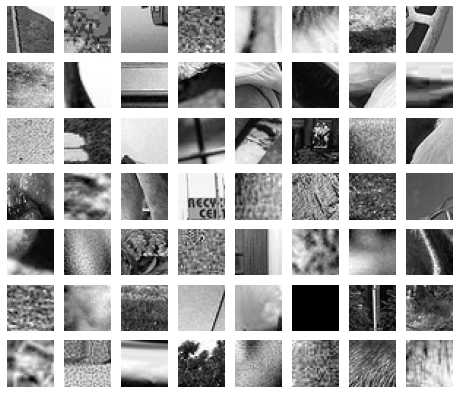

In [6]:
print(X.shape)
print(X.min())
print(X.max())
visualize_image(X,7,8)
# plt.savefig("figures/imgs.pdf")

# PCA Analysis

In [7]:
# Zero center
row_mean = X.mean(axis=1)
X_zero = X - row_mean.reshape([-1, 1])

In [8]:
# PCA
pca = decomposition.PCA()
pca.fit(X_zero.T)
pca_basis = pca.components_
pca_basis.shape

(1024, 1024)

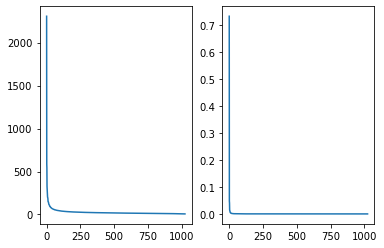

In [9]:
# Plot eigenval
plt.subplot(1, 2, 1)
plt.plot(pca.singular_values_)

plt.subplot(1, 2, 2)
plt.plot(pca.explained_variance_ratio_)
plt.show()

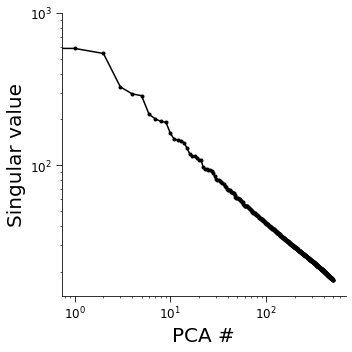

In [10]:
plt.figure(figsize=(5,5))
plt.plot(pca.singular_values_[:int(500)],'k.-')
ax=plt.gca()
simpleaxis(ax)
ax.set_xscale('log')
ax.set_yscale('log')
plt.ylim(top=1000)
# plt.xlim(1,100)
plt.xlabel("PCA #",fontsize=20)
plt.ylabel("Singular value",fontsize=20)
plt.tight_layout()
# plt.savefig("figures/PCA_spectrum.svg")

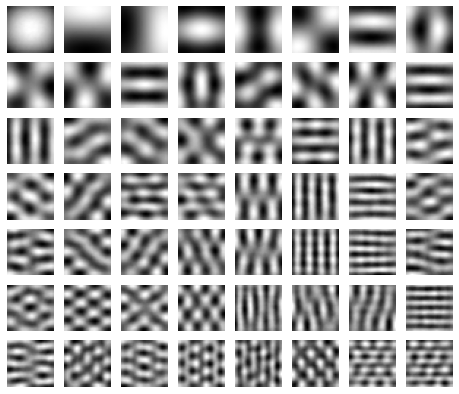

In [11]:
# PCA Basis
visualize_image(pca_basis.T, n_row=7, n_col=8, rand=False)
# plt.savefig("figures/pca_basis.pdf")

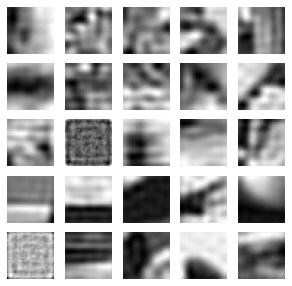

In [190]:
# PCA transformation
n_comp = 50
comp = pca_basis[:n_comp, :]

proj = comp @ X_zero
recon = comp.T @ proj
recon_mean = recon + row_mean.reshape([-1, 1])

visualize_image(recon_mean)

In [191]:
# PCA loss
loss_func = nn.MSELoss()
loss_func(torch.from_numpy(X_zero.T.astype(np.float32)), \
          torch.from_numpy(recon.T.astype(np.float32)))

tensor(0.0047)

# PCA with Neural Network

### Helper class and function

In [12]:
input_X = torch.from_numpy(X_zero.T.astype(np.float32)).cuda()

import functools as ft
class LinearNetwork:
  # init with a list of weight matrix
  def __init__(self, pca_basis, init_scale, *weight_shape):
    self.weight = [(torch.rand(mtx_shape)*init_scale-init_scale/2)\
                   .clone().detach().cuda().requires_grad_(True)\
                   for mtx_shape in weight_shape]
    self.symmetric=False
    self.pca_basis = torch.from_numpy(pca_basis.astype(np.float32)).cuda()

  def transform_mtx(self):
    # pca transformation encoded by the network
    w = ft.reduce(lambda a, b: b.mm(a), self.weight)
    return w.t().mm(w) if self.symmetric else w

  def forward(self, input):
    # forward transformation on data
    transform = self.transform_mtx()
    return input.mm(transform)
    
  def decompose(self):
    # alignment with PCA basis
    with torch.no_grad():
      transform = self.transform_mtx()
      if not self.symmetric: 
        transform = transform.mm(transform.t())

      diag = self.pca_basis.mm(transform).mm(self.pca_basis.T)      

      return np.diag(diag.detach().cpu().numpy())

  # useful visualization
  def plot_decomposition(self, n_item):
    diag = self.decompose()[:n_item]
    plt.plot(diag)
    plt.show()

  def show_reconstruction(self, input):
    with torch.no_grad():
      output = self.forward(input).detach().cpu().numpy().T
      visualize_image(output)

    

In [13]:
def pca_learning(input, network, n_epoch=1000, batch_size=100, n_item=50, sgd=True, lr=0.01, return_weight_every=False):
  # Gradient descent training
  optimizer = optim.SGD(network.weight, lr=lr)  
  if not sgd:
    optimizer = optim.Adam(network.weight)

  loss_func = nn.MSELoss()
  loss_val  = np.zeros(n_epoch)
  diag_val  = np.zeros([n_epoch, n_item])

  weights=[]
  for epoch in tqdm(range(n_epoch)): 
    if return_weight_every is not None:
        if epoch % return_weight_every ==0:
            weights.append(network.weight[0].detach().cpu())
    # diagonalization of network transformation with PCA basis
    diag = network.decompose()
    diag_val[epoch, :] = diag[0:n_item]
    
    # SGD training
    shuffle_idx = np.random.permutation(len(input))
    batches = torch.split(input[shuffle_idx], batch_size)
    
    for batch in batches:
        optimizer.zero_grad()
        output = network.forward(batch)
    
        loss = loss_func(batch, output + torch.randn_like(output)*.1)
        loss.backward()        
        optimizer.step()

        
    # evalulation after each epoch
    with torch.no_grad():
        output = network.forward(input)
        loss_val[epoch] = loss_func(input, output)

  if return_weight_every is not None:
    return (loss_val, diag_val, weights)
  return (loss_val, diag_val)

In [14]:
# helper function for plotting the loss function
def plot_loss(loss_val):
  fig = plt.figure(figsize=(10, 3), dpi=100)
  plt.subplot(1, 2, 1)
  plt.plot(loss_val)

  n_epoch = loss_val.size
  index = int(n_epoch * 0.75)
  plt.subplot(1, 2, 2)
  plt.plot(range(n_epoch)[index:], loss_val[index:])

In [15]:
# helper function for temporal dynamics
def plot_temporal(diag_val, t_step, n_plot=20,cmap="Blues"):
  colors = sns.color_palette(cmap,n_colors=n_plot)
  for idx in range(n_plot):
    plt.plot(range(t_step), diag_val[:t_step, idx], c=colors[-(idx+1)])
  

In [16]:
def sinusoid(freq,phase=0, contrast=1):
    arr= torch.ones(1,32,32)
    arr*=torch.linspace(0,3.14159,32)
    arr = contrast*.5*torch.sin(freq*arr+phase)+.5
    return arr.view(-1,32**2).cuda()

def get_sensitivity(net, low=1,high=10,n=20, weight=None, n_phases=64, plot=True, log_x=False,contrast=1):
    fs = [torch.autograd.Variable(f, requires_grad=True) for f in torch.linspace(low,high,n)]
    if weight is None:
        w = ft.reduce(lambda a, b: b.mm(a), net.weight)
    else:
        w = weight

    sensitivity=[]
    for f in fs:
        all_sens=[]
        for phase in np.linspace(0,np.pi,n_phases):
            func = lambda l: sinusoid(l,phase,contrast).mm(w.t())
            all_sens.append(torch.autograd.functional.jacobian(func, f, vectorize=True).pow(2).sum())
        sensitivity.append(np.mean(all_sens))
        
    if plot:
        fig = plt.figure(figsize=(8, 4), dpi=300)
        plt.subplot(1, 2, 1)
        plt.plot(np.linspace(low,high,n)/64*100,sensitivity)
        plt.ylabel("Fisher Information")
        plt.xlabel("Spatial frequency (cycles/ 100 pixels)")
        if log_x:
            plt.gca().set_xscale('log')
        plt.subplot(1,2,2)

        plt.plot(np.linspace(low,high,n)/64*100,np.power( sensitivity,-.5))
        plt.xlabel("Cycles/ 100 pixels")
        plt.ylabel(r"Threshold $J(\theta)^{-\frac{1}{2}}$")
        if log_x:
            plt.gca().set_xscale('log')
    else:
        return sensitivity


### One-matrix reconstruction

$$\hat{X}=W_1X$$
$$\ell(W)=\sum_j(x_j-\hat{x_j})^2$$

#### Before training

In [17]:
n_comp = 50
input_size = 32 * 32

one_layer = LinearNetwork(pca_basis, 0.01, (input_size, input_size))
one_layer.symmetric=True

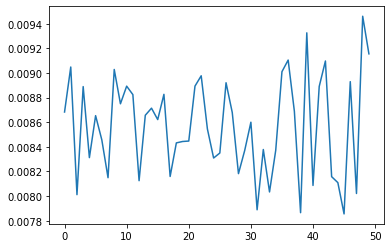

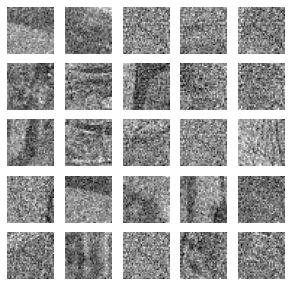

In [18]:
# Before training, diagonalization with PCA basis
one_layer.plot_decomposition(n_item=50)
one_layer.show_reconstruction(input_X)

#### Training

In [19]:
# Training
loss_val, diag_val, weights = pca_learning(input_X, one_layer, n_epoch=1000, batch_size=16384, n_item=50, sgd=True,
                                 lr=1, return_weight_every=1)

100%|██████████| 1000/1000 [01:39<00:00, 10.00it/s]


Text(0, 0.5, 'Proportion learned')

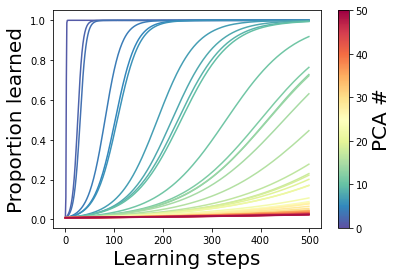

In [20]:
def plot_temporal(diag_val, t_step, n_plot=20,cmap="Blues"):
  colors = sns.color_palette(cmap,n_colors=n_plot)
  for idx in range(n_plot):
    p=plt.plot(range(t_step), diag_val[:t_step, idx], c=colors[-(idx+1)])
  sm = plt.cm.ScalarMappable(cmap=plt.get_cmap(cmap+'_r'), norm=plt.Normalize(0,n_plot))
  cb=plt.colorbar(sm)
  cb.set_label(label="PCA #", fontsize=20)

  

plot_temporal(diag_val, t_step=500, n_plot=50, cmap='Spectral')
plt.xlabel("Learning steps", fontsize=20)
plt.ylabel("Proportion learned", fontsize=20)
# plt.savefig("figures/pca_learning_1layer.svg")

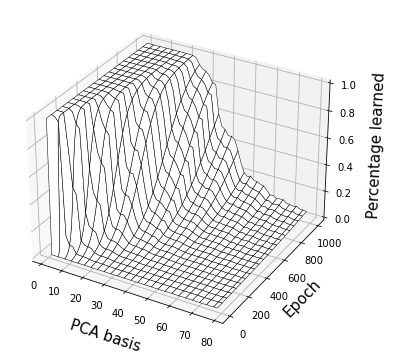

In [21]:
def learning_3d(diag_val, low=1,high=50, n_epoch=1000, n_every=100):
    n=n_epoch//n_every
    fig = plt.figure(figsize=(8,5))
    ax = fig.add_subplot(111, projection='3d')
    m=1
    x = np.linspace(low,high)/64*100
    y = np.arange(0,n_epoch, n_every//m)
    X,Y = np.meshgrid(x,y)
    Z = np.zeros((len(y),len(x)))
    
    for i in range(n):
        
        
        Z[m*i] = diag_val[i*n_every]
    ax.plot_surface(X, Y, Z, rstride=50, cstride=2, color='w', 
                        shade=False, lw=.5, edgecolors='k', zorder=10)

    ax.set_zlim(0, 1)
#     ax.set_xlim(-51, 51)
    ax.set_zlabel("Percentage learned",fontsize=15,labelpad=10)
    ax.set_xlabel("PCA basis",fontsize=15,labelpad=10)
    ax.set_ylabel("Epoch", fontsize=15)
    plt.tight_layout()
#     ax.view_init(30,-70)
learning_3d(diag_val, n_every=1)

#### Fisher of each basis
This is $\sum_i\frac{\partial Wx}{\partial v_i}^2x$. In the axis-aligned case it's $\sigma_i(t)$.

#### Sinusoidal gratings

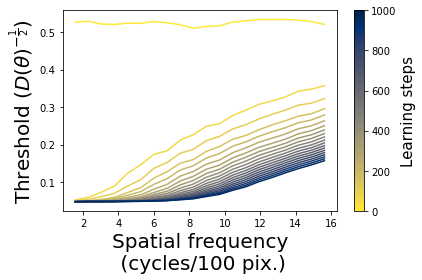

In [23]:
def plot_webers(list_of_weights, low=1,high=10,n_x=20, n_epoch=1000, n_every=50, n_phases=1, which=None,
               cmap='cividis_r', contrast=1):
    n=len(list_of_weights)
#     fig = plt.figure(figsize=(6,5), dpi=100)
    colors = sns.color_palette(cmap,n_colors=n, )

    m=10
    x = np.linspace(low,high,n_x)/64*100
    if which is None:
        which = range(0,n,n_every)
    for i in which:
        sensitivity = get_sensitivity(None, weight=list_of_weights[i].cuda(), n_phases=n_phases, plot=False, 
                                      n=n_x, contrast=contrast)

        plt.plot(x,np.power( sensitivity,-.5), c=colors[i])
    sm = plt.cm.ScalarMappable(cmap=plt.get_cmap(cmap), norm=plt.Normalize(0,n_epoch))
    cb=plt.colorbar(sm)
    cb.set_label(label="Learning steps", fontsize=15)
    plt.xlabel("Spatial frequency\n (cycles/100 pix.)", fontsize=20)
    plt.ylabel(r"Threshold ($D(\theta)^{-\frac{1}{2}}$)", fontsize=20)
    
plot_webers(weights[:], which=list(range(0,1000,50)) ,n_phases=16, contrast=1)
plt.tight_layout()
# plt.savefig("figures/webers_1layer.svg")

In [24]:
def time_to_thresh(weights, sigma, delta=0.01):
    thresholds =[]
    thresh=1
    jnd=10
    old_jnd=10
    for w in tqdm(weights):
        included=False
        while not included:
            sensitivity = get_sensitivity(None, low=thresh,high=thresh+delta,n=1, weight=w.cuda(), 
                                          n_phases=64, plot=False, log_x=False)
            jnd = np.power(sensitivity,-.5)[0]
            if jnd > sigma and old_jnd < sigma:
                thresholds.append(thresh)
                included=True
                old_jnd=0
            elif thresh>20:
                thresh=0
                thresholds.append(thresh)
                included=True
            else: 
                thresh+=delta
                old_jnd=jnd
            
    return thresholds
thresholds=time_to_thresh(weights[2:],.1, .05)

100%|██████████| 998/998 [06:33<00:00,  2.54it/s]


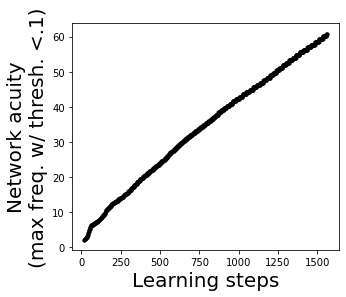

In [26]:
plt.figure(figsize=(5,4))

x=np.arange(2,1000)/64*100
y=thresholds
plt.plot(x[10:],np.power(thresholds[10:],2),'.',c='k')
# plt.gca().set_yscale('log')
# plt.gca().set_xscale('log')
plt.ylabel("Network acuity\n(max freq. w/ thresh. <.1)",fontsize=20)
plt.xlabel("Learning steps",fontsize=20)
plt.tight_layout()
# plt.savefig("figures/linear_learning_linscale.svg")

### Two-Layer

$$\hat{X}=W_2W_1X$$

In [27]:
n_comp = 50
input_size = 32 * 32

deep_net = LinearNetwork(pca_basis, 0.01, (input_size, input_size), (input_size, input_size))

In [28]:
# Training
n_epoch =1000
loss_val, diag_val,weights2 = pca_learning(input_X, deep_net, n_epoch=n_epoch, batch_size=4096, n_item=50, sgd=True, lr=1, 
                                 return_weight_every=10)

100%|██████████| 1000/1000 [02:16<00:00,  7.34it/s]


Text(0, 0.5, 'Proportion learned')

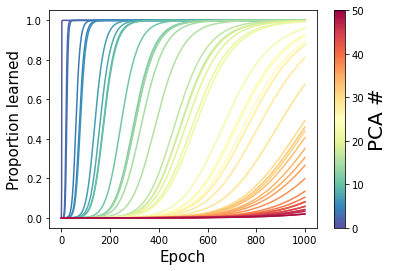

In [29]:
plot_temporal(diag_val, t_step=1000, n_plot=50, cmap='Spectral')
plt.xlabel("Epoch", fontsize=15)
plt.ylabel("Proportion learned", fontsize=15)
# plt.savefig("pca_learning_2layer.pdf")

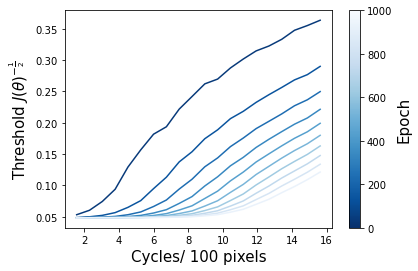

In [30]:
def plot_webers(list_of_weights, low=1,high=10,n_x=20, n_epoch=1000, n_every=50, n_phases=1,
               cmap='Blues_r',from_=0):
    n=len(list_of_weights)
#     fig = plt.figure(figsize=(6,5), dpi=100)
    colors = sns.color_palette(cmap,n_colors=n)

    m=10
    x = np.linspace(low,high,n_x)/64*100
    
    for i in range(from_,n,n_every):
        sensitivity = get_sensitivity(None, weight=list_of_weights[i].cuda(), n_phases=n_phases, plot=False, n=n_x)

        plt.plot(x,np.power( sensitivity,-.5), c=colors[i])
    sm = plt.cm.ScalarMappable(cmap=plt.get_cmap(cmap), norm=plt.Normalize(0,n_epoch))
    cb=plt.colorbar(sm)
    cb.set_label(label="Epoch", fontsize=15)
    plt.xlabel("Cycles/ 100 pixels", fontsize=15)
    plt.ylabel(r"Threshold $J(\theta)^{-\frac{1}{2}}$", fontsize=15)
plot_webers(weights2, from_=3, n_every=10,n_phases=27)
# plt.savefig("webers_2layer.pdf")

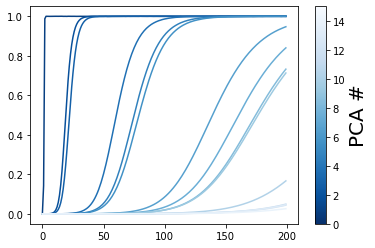

In [33]:
plot_temporal(diag_val, t_step=200, n_plot=15)

### Three-Layer

$$\hat{X}=W_3W_2W_1X$$

In [36]:
n_comp = 50
input_size = 32 * 32

three_net = LinearNetwork(pca_basis, 0.02, (input_size, input_size),(input_size, input_size), (input_size, input_size))

In [37]:
# Training
n_epoch = 1000
loss_val, diag_val, weights3 = pca_learning(input_X, three_net, n_epoch=n_epoch, batch_size=4096, n_item=50, sgd=True, lr=1,
                                 return_weight_every=100)

100%|██████████| 1000/1000 [02:52<00:00,  5.80it/s]


Text(0, 0.5, 'Proportion learned')

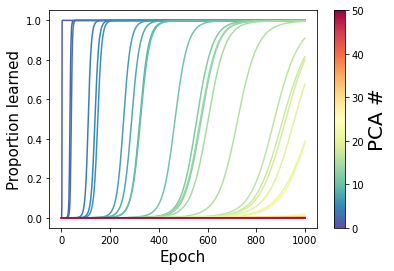

In [38]:
plot_temporal(diag_val, t_step=1000, n_plot=50, cmap='Spectral')
plt.xlabel("Epoch", fontsize=15)
plt.ylabel("Proportion learned", fontsize=15)
# plt.savefig("pca_learning_3layer.pdf")

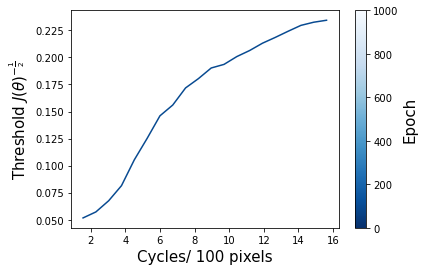

In [39]:
plot_webers(weights3[1:], n_every=100,n_phases=27)
# plt.savefig("webers_3layer.pdf")

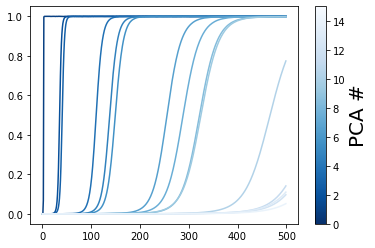

In [42]:
plot_temporal(diag_val, t_step=500, n_plot=15)
# plt.axis('off')
# plt.savefig("Evolution.pdf")

plt.show()

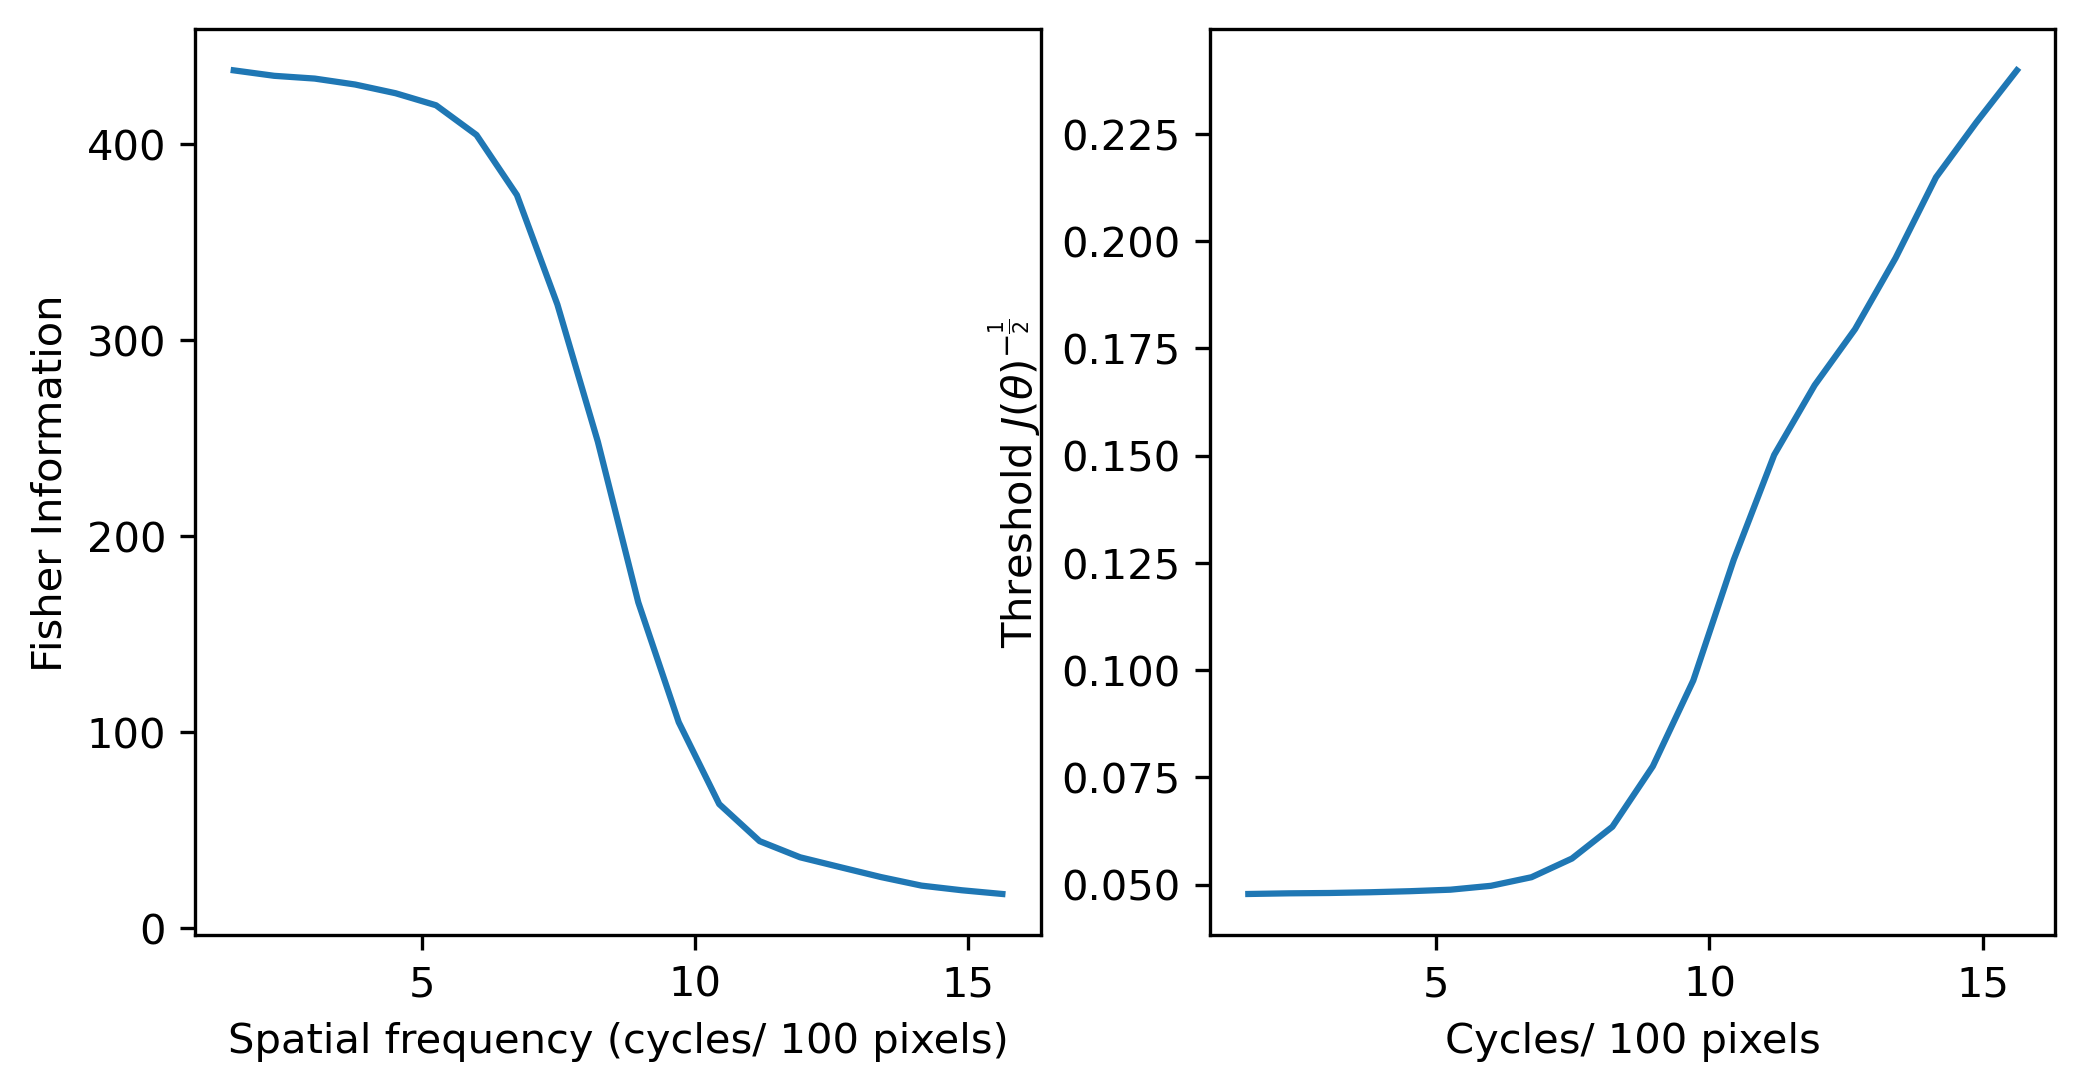

In [43]:
get_sensitivity(three_net)